In [1]:
from bs4 import BeautifulSoup
import requests
import re
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
def getsoup(url):
    header = {'User-Agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/96.0.4664.55 Safari/537.36 Edg/96.0.1054.43'
            }
    response = requests.get(url,headers=header)
    soup = BeautifulSoup(response.text,"html.parser")
    return response, soup

<h1>愛料理 

In [3]:
food = input('輸入食物: ')
url_icook = f"https://icook.tw/search/{food}"
response_icook, soup_icook = getsoup(url_icook)

data_icook = {'Name':[],'Materials':[],'Time':[],'Like':[]}
flag = True
pages = 0
#取得各頁
while flag:
    div_icook = soup_icook.find_all(class_="browse-recipe-item")
    for i in range(len(div_icook)):
        name = div_icook[i].find('h2').text.strip()
        material = div_icook[i].find('p').text.strip()
        material = re.sub(r'食材：', '', material).split('、')
        # 處理網站內meta標籤
        metas = div_icook[i].find_all('li', class_="browse-recipe-meta-item")
        for meta in metas:
            meta = meta.text.strip()
            if '分' in meta:
                time = re.sub(r'[分,]','',meta)
            elif '讚' in meta:
                like = re.sub(r'[讚,]','',meta)
            else:
                break
        # 存至data
        data_icook['Name'].append(name), data_icook['Materials'].append(material)
        data_icook['Time'].append(time), data_icook['Like'].append(like)
    #下一業
    try:
        pages = pages+ 1
        page_flag = eval(soup_icook.find_all('a', class_="pagination-tab-link--number")[-1].text)-1
        if pages>page_flag:
            flag = False
        else:    
            url_icook = f"https://icook.tw/search/{food}/?page={pages}"
            print(url_icook)
            response_icook, soup_icook = getsoup(url_icook)
    except:
        flag = False
        
#取得最後一頁
url_icook = f"https://icook.tw/search/{food}/?page={pages}"
print(url_icook)
response_icook, soup_icook = getsoup(url_icook)
div_icook = soup_icook.find_all(class_="browse-recipe-item")
for i in range(len(div_icook)):
    name = div_icook[i].find('h2').text.strip()
    material = div_icook[i].find('p').text.strip()
    material = re.sub(r'食材：', '', material).split('、')
    metas = div_icook[i].find_all('li', class_="browse-recipe-meta-item")
    for meta in metas:
        meta = meta.text.strip()
        if '分' in meta:
            time = re.sub(r'[分,]','',meta)
        elif '讚' in meta:
            like = re.sub(r'[讚,]','',meta)
        else:
            break
    data_icook['Name'].append(name), data_icook['Materials'].append(material)
    data_icook['Time'].append(time), data_icook['Like'].append(like)
    
# DataFrame
Icook = pd.DataFrame.from_dict(data_icook)
print('Finish')


輸入食物: 燒賣
https://icook.tw/search/燒賣/?page=1
https://icook.tw/search/燒賣/?page=2
https://icook.tw/search/燒賣/?page=3
https://icook.tw/search/燒賣/?page=4
https://icook.tw/search/燒賣/?page=5
https://icook.tw/search/燒賣/?page=6
Finish


## 圖表設定

In [4]:
#str轉int
Icook['Like'], Icook['Time'] = Icook['Like'].astype(int), Icook['Time'].astype(int)
#排序
Icook = Icook.sort_values(by=['Like'], ascending=False,)
#Style
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
print(f'共{len(Icook)}項')

Icook.to_csv(f'{food}食譜.csv',encoding='utf-8-sig')
(Icook.style
 .set_caption(f'{food}大全')
 .bar('Time', vmin=0)
 .background_gradient('Blues', subset='Like')
)

共126項


,Name,Materials,Time,Like
91,蛤蜊蒸燒賣,"['蛤蜊', '蝦仁', '豬絞肉', '乾香菇', '香菜', '太白粉水', '鹽', '糖', '白胡椒粉', '麻油', '太白粉']",60,5372
88,翠玉燒賣（日本超流行包法）,"['小捲心菜', '燒賣皮', '薑絲', '葱丁', '辣椒丁', '香油', '辣油', '醬油', '醋', '蜂蜜']",20,2208
68,鮮蝦燒賣 【港式點心】,"['鮮蝦', '豬絞肉', '醬油', '雲吞皮', '香油', '白胡椒粉', '鹽', '太白粉', '糖']",45,1947
115,蝦仁燒賣,"['港式餛飩皮', '豬絞肉', '蝦仁', '蔬菜類', '雞蛋', '薑泥/蒜泥', '醬油', '雞粉', '白胡椒粉']",45,1264
85,香菇鑲肉燒賣（日本超流行）,"['生香菇', '燒賣皮', '豬絞肉', '金針菇細丁', '葱末', '薑泥', '蠔油', '香油', '胡椒粉', '塩', '糖']",60,1236
101,鮮蝦港式燒賣,"['細的豬絞肉', '蝦仁', '薑末', '蔥', '餛飩皮', '調味:蒜粉', '調味:鹽', '調味:糖', '調味:米酒', '調味:胡椒粉', '調味:香油', '調味:太白粉', '調味:水或高湯', '毛豆', '玉米粒']",45,1178
55,日式花燒賣,"['豬絞肉', '燒賣皮', '醬油', '洋蔥', '料理酒', '薑末', '鹽', '蒜蓉', '糖', '太白粉', '胡椒粉', '香油或麻油']",30,953
103,鮮蝦燒賣,"['餛飩皮', '豬絞肉', '鮮蝦仁', '蔥末', '薑泥', '香油', '米酒', '鹽', '醬油', '白胡椒粉', '水', '玉米粒']",20,938
89,簡單豬肉燒賣。,"['豬肉末', '馬蹄', '洋蔥', '生姜', '香蔥', '白酒', '醬油', '芝麻油', '鹽', '木薯粉/粟粉', '蛋白', '餛飩皮']",45,767
97,蛤蜊綠咖哩燒賣【穀盛綠咖哩】,"['蛤蜊', '絞肉', '草蝦仁', '蔥珠', '香菇丁', '紅甜椒丁', '綠花椰菜', '穀盛綠咖哩', '水']",30,652


## 材料種類

In [5]:
def to_1D(series):
    return pd.Series([x for _list in series for x in _list])

Material_Types = to_1D(Icook['Materials']).value_counts()
Material_Types

鹽                          56
香油                         49
醬油                         41
豬絞肉                        40
太白粉                        37
胡椒粉                        30
餛飩皮                        29
糖                          27
白胡椒粉                       25
米酒                         22
蝦仁                         22
水                          18
中筋麵粉                       15
薑                          15
絞肉                         15
鹽巴                         14
紅蘿蔔                        14
燒賣皮                        13
洋蔥                         13
薑末                         13
乾香菇                        13
蠔油                         13
蔥                          12
麻油                         12
胡椒                         11
香菇                         10
雞蛋                          9
白胡椒                         9
薑泥                          8
蔥花                          8
砂糖                          7
味霖                          7
蒜                           7
蒜末        

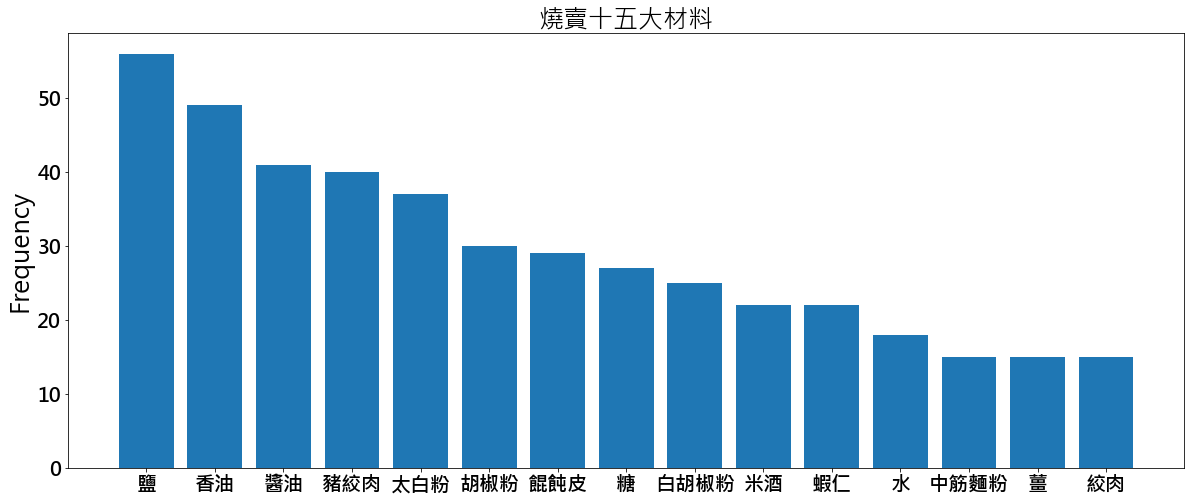

In [6]:
font = {'family' : 'Microsoft JhengHei',
'weight' : 'bold',
'size'  : '20'}
plt.rc('font', **font) 

fig, ax = plt.subplots(figsize = (20,8))
ax.bar(Material_Types.index[:15],
        Material_Types.values[:15])
ax.set_ylabel("Frequency", size = 25)
ax.set_title(f"{food}十五大材料", size = 25)
plt.savefig(f"{food}Material15.png", dpi = 300)

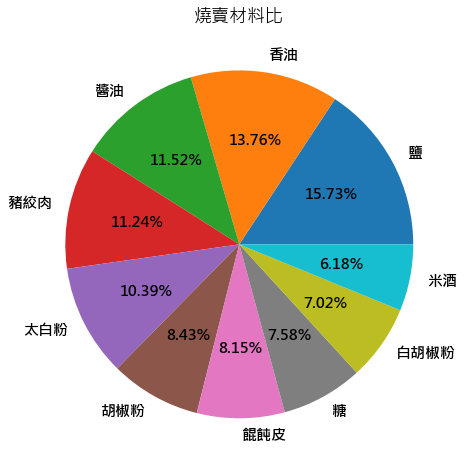

In [7]:
font = {'family' : 'Microsoft JhengHei',
'weight' : 'bold',
'size'  : '15'}
plt.rc('font', **font) 

fig, ax = plt.subplots(figsize = (20,8))
plt.pie(Material_Types[:10], labels=Material_Types.index[:10], autopct='%1.2f%%')
plt.title(f'{food}材料比')
plt.savefig(f"{food}Material_Pie.png", dpi = 300)
plt.show()